<a href="https://colab.research.google.com/github/zhang-linnng/convex_restriction_transformed/blob/main/projection_updated0829_convexRestriction_WB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq libglpk-dev
!pip install cvxpy

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [3]:
!pip install pypower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.0/347.0 kB 4.4 MB/s eta 0:00:00


# Import libraries

In [4]:
from __future__ import division
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from mpl_toolkits.mplot3d import Axes3D
import random
import pandas as pd
import math
import json
import pickle
import cmath
import sys

random.seed(1234321)

# Project folder

In [5]:
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        # Create a new directory if it does not exist
        os.makedirs(path)
        print("The new directory %s is created!" % (path))

In [6]:
project_path = "/content/gdrive/MyDrive/2023Projects/convex_restriction/WB3/"
ourMethod_path = project_path  + "our_method/"
socp_path = project_path  + "socp/"
# sdp_path = project_path  + "sdp/"
newtonRaphson_path = project_path  + "newton_raphson/"
settings_path = project_path + "grid_WB3/"

In [7]:
create_dir(settings_path)
create_dir(ourMethod_path)
create_dir(socp_path)
create_dir(newtonRaphson_path)

# Grid representation

## Parameters

In [8]:
import scipy.io as sio

# mat_contents = sio.loadmat(settings_path + mat_fname)
branch_contents = sio.loadmat(settings_path + 'branch_WB3.mat')
bus_contents = sio.loadmat(settings_path + 'bus_WB3.mat')
gen_contents = sio.loadmat(settings_path + 'gen_WB3.mat')

print(branch_contents.keys())
print(bus_contents.keys())
print(gen_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'branch'])
dict_keys(['__header__', '__version__', '__globals__', 'bus'])
dict_keys(['__header__', '__version__', '__globals__', 'gen'])


In [9]:
## branch data: fbus(0), tbus(1), r(2), x(3), b(4)
## bus data: bus(0), type(1), Pd(2), Qd(3), Vmx(11), Vmn(12)
## gen data: bus(0), Pg(1), Qg(2), Qmax(3), Qmin(4), Pmax(8), Pmin(9)

branch_data = branch_contents['branch']
bus_data = bus_contents['bus']
gen_data = gen_contents['gen']

branch_array = np.concatenate([branch_data[:,0:1], branch_data[:,1:2], branch_data[:,2:3], branch_data[:,3:4], branch_data[:,4:5]], axis=1)
branch_df = pd.DataFrame(branch_array, columns = ['fbus','tbus','r','x','b'])
branch_df['fbus'] = branch_df['fbus'].apply(lambda x: int(x))
branch_df['tbus'] = branch_df['tbus'].apply(lambda x: int(x))

bus_array = np.concatenate([bus_data[:,0:1], bus_data[:,1:2], bus_data[:,2:3], bus_data[:,3:4], bus_data[:,11:12], bus_data[:,12:13]], axis=1)
bus_df = pd.DataFrame(bus_array, columns = ['bus','type','Pd','Qd','Vmx','Vmn'])
bus_df['bus'] = bus_df['bus'].apply(lambda x: int(x))
bus_df['type'] = bus_df['type'].apply(lambda x: int(x))

gen_array = np.concatenate([gen_data[:,0:1], gen_data[:,1:2], gen_data[:,2:3], gen_data[:,3:4], gen_data[:,4:5], gen_data[:,8:9], gen_data[:,9:10]], axis=1)
gen_df = pd.DataFrame(gen_array, columns = ['bus','Pg','Qg','Qmax','Qmin','Pmax','Pmin'])
gen_df['bus'] = gen_df['bus'].apply(lambda x: int(x))

In [10]:
branch_df = branch_df.sort_values(by=['fbus', 'tbus'], ascending=True)

In [11]:
branch_df.head()

,fbus,tbus,r,x,b
0,1,2,0.0400,0.2000,0.000
1,2,3,0.0139,0.0605,2.459


In [12]:
gen_df.head()

,bus,Pg,Qg,Qmax,Qmin,Pmax,Pmin
0,1,300.0,129.0,3000.0,-3000.0,5000.0,0.0


In [13]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn
0,1,3,0.000,0.000,1.4,0.6
1,2,1,0.120,0.086,1.4,0.6
2,3,1,0.068,0.050,1.4,0.6


In [14]:
r_ij = branch_df["r"].to_numpy()
x_ij = branch_df["x"].to_numpy()
g_ij = r_ij/(r_ij**2+x_ij**2)
b_ij = x_ij/(r_ij**2+x_ij**2)
branch_df["conductance(g)"] = g_ij
branch_df["susceptance(b)"] = b_ij
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b)
0,1,2,0.0400,0.2000,0.000,0.961538,4.807692
1,2,3,0.0139,0.0605,2.459,3.607148,15.700176


In [15]:
count_lines_df = branch_df.groupby(['fbus', 'tbus']).count()
count_lines_df.head()
branches = count_lines_df.index.to_list()
branches_list = [(int(x[0]), int(x[1])) for x in branches]
print(branches_list)

nodes = bus_df['bus'].to_list()
nodes_list = [int(x) for x in nodes]
print(nodes_list)

num_nodes = len(nodes_list)
num_branches = len(branches_list)
print('num_nodes:', num_nodes)
print('num_branches:', num_branches)

[(1, 2), (2, 3)]
[1, 2, 3]
num_nodes: 3
num_branches: 2


In [16]:
bus_to_numeric = dict()

for k in range(num_nodes):
    node_idx = nodes_list[k]
    bus_to_numeric[node_idx] = k

bus_to_neighbors = dict()
for edge in branches_list:
    fbus = edge[0]
    tbus = edge[1]
    if fbus not in bus_to_neighbors.keys():
        bus_to_neighbors[fbus] = [tbus]
    else:
        bus_to_neighbors[fbus] += [tbus]

    if tbus not in bus_to_neighbors.keys():
        bus_to_neighbors[tbus] = [fbus]
    else:
        bus_to_neighbors[tbus] += [fbus]

print('bus_to_numeric:', bus_to_numeric)
print('bus_to_neighbors:', bus_to_neighbors)


bus_to_numeric: {1: 0, 2: 1, 3: 2}
bus_to_neighbors: {1: [2], 2: [1, 3], 3: [2]}


In [17]:
numbering_links = dict()
for i in range(num_branches):
    fbus = branch_df.iloc[i, 0]
    tbus = branch_df.iloc[i, 1]
    numbering_links[i] = (fbus, tbus)
print('numbering_links:', numbering_links)

numbering_links: {0: (1, 2), 1: (2, 3)}


In [18]:
# incidence matrix
E = np.zeros((num_branches, num_nodes))
for m in range(num_branches):
    f_end = branch_df.iloc[m, 0]
    t_end = branch_df.iloc[m, 1]

    col1 = bus_to_numeric[f_end]
    col2 = bus_to_numeric[t_end]

    if col1 < col2:
        E[m, col1] = 1
        E[m, col2] = -1
    else:
        E[m, col1] = -1
        E[m, col2] = 1

print('E:', E)

E: [[ 1. -1.  0.]
 [ 0.  1. -1.]]


In [19]:
gen_set_mask = bus_df['type']>1
gen_set = bus_df['bus'][gen_set_mask]
gen_rows = np.array(range(num_nodes))[gen_set_mask]
print('gen_set:\n', gen_set)
print('gen_rows:\n', gen_rows)

gen_set:
 0    1
Name: bus, dtype: int64
gen_rows:
 [0]


In [20]:
bus_lists = bus_df['bus'].to_numpy()
print(bus_lists.shape)
print(bus_lists)

(3,)
[1 2 3]


In [21]:
branch_df['index'] = branch_df.index
branch_df.head()

b_for_lines = b_ij.reshape(-1,1)
g_for_lines = g_ij.reshape(-1,1)

##  Vectorize power flow equations

### Define matrices

In [22]:
G_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_a[row, col] = -g_ij[col]

            else: # if row < neighbor
                G_a[row, col] = -g_ij[col]


B_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_a[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_a[row, col] = b_ij[col]


print('G_a:', G_a.shape)
print('B_a:', B_a.shape)

G_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    G_hat[row, col] = g_ij[m]
    G_hat[col, row] = g_ij[m]

print('G_hat:', G_hat.shape)


d_active = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_active[row, 0] = np.sum(G_hat[row,:])

print('d_active:', d_active.shape)

A = np.block([
    G_a, B_a, d_active
])
print('A:', A.shape)

G_a: (3, 2)
B_a: (3, 2)
G_hat: (3, 3)
d_active: (3, 1)
A: (3, 5)


In [23]:
G_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_r[row, col] = g_ij[col]

            else: # if row < neighbor
                G_r[row, col] = -g_ij[col]


B_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_r[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_r[row, col] = -b_ij[col]


print('G_r:', G_r.shape)
print('B_r:', B_r.shape)


B_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    B_hat[row, col] = b_ij[m]
    B_hat[col, row] = b_ij[m]

print('B_hat:', B_hat.shape)

d_reactive = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_reactive[row, 0] = np.sum(B_hat[row,:])

print('d_reactive:', d_reactive.shape)

R = np.block([
    B_r, G_r, d_reactive
])
print('R:', R.shape)

G_r: (3, 2)
B_r: (3, 2)
B_hat: (3, 3)
d_reactive: (3, 1)
R: (3, 5)


### Power flow equations

In [24]:
def p_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

nominal_angle = np.zeros(num_nodes)
p = p_in_voltage(nominal_angle)
q = q_in_voltage(nominal_angle)
print(p)
print(q)

[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]


## Nodal power bounds

In [25]:
bus_df['Pmax'] = bus_df['bus']
bus_df['Pmin'] = bus_df['Pd']
bus_df['Qmax'] = bus_df['Pd']
bus_df['Qmin'] = bus_df['Pd']
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,3,0.000,0.000,1.4,0.6,1,0.000,0.000,0.000
1,2,1,0.120,0.086,1.4,0.6,2,0.120,0.120,0.120
2,3,1,0.068,0.050,1.4,0.6,3,0.068,0.068,0.068


In [26]:
gen_df_copy = gen_df.copy()
gen_df_copy = gen_df_copy.set_index('bus')
gen_df_copy.head()

,Pg,Qg,Qmax,Qmin,Pmax,Pmin
bus,,,,,,
1,300.0,129.0,3000.0,-3000.0,5000.0,0.0


In [27]:
for i in range(num_nodes):
    bus = bus_df.iloc[i, 0]
    type = bus_df.iloc[i, 1]
    if type > 1: # generator or slack(reference) buses, copy everything
        bus_df.loc[i, 'Pmax']= gen_df_copy.loc[bus, 'Pmax']
        # bus_df.loc[i, 'Pmin']= gen_df_copy.loc[bus, 'Pmin']
        bus_df.loc[i, 'Pmin']= 0
        bus_df.loc[i, 'Qmax']= gen_df_copy.loc[bus, 'Qmax']
        bus_df.loc[i, 'Qmin']= gen_df_copy.loc[bus, 'Qmin']

    else:
       # load buses, Pmax = -Pd; Pmin

        bus_df.loc[i, 'Pmax'] = -bus_df['Pd'][i]
        bus_df.loc[i, 'Pmin'] = -10. # set a maximum loading at this bus,
        # based on the generators's capacity, which is 10, I set the maximum loading to be 10

        # # this results in infeasibility
        # bus_df.loc[i, 'Qmax'] = bus_df['Qd'][i] # positive Qmax means maximum reactive power that
        # # this load bus can consume
        # bus_df.loc[i, 'Qmin'] = 0. # postive Q min means that this load bus cannot contribute(generate)
        # # reactive power
        bus_df.loc[i, 'Qmax'] = 10. # this is the maximum reactive power that generator bus can contribute
        bus_df.loc[i, 'Qmin'] = bus_df['Qd'][i]


bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,3,0.000,0.000,1.4,0.6,5000.000,0.0,3000.0,-3000.000
1,2,1,0.120,0.086,1.4,0.6,-0.120,-10.0,10.0,0.086
2,3,1,0.068,0.050,1.4,0.6,-0.068,-10.0,10.0,0.050


In [28]:
Pd = bus_df['Pd'].to_numpy()
print('Pd:', Pd)

Qd = bus_df['Qd'].to_numpy()
print('Qd:', Qd)

Qmax = bus_df['Qmax'].to_numpy()
Qmin = bus_df['Qmin'].to_numpy()
Pmax = bus_df['Pmax'].to_numpy()
Pmin = bus_df['Pmin'].to_numpy()
print('Qmax shape:', Qmax.shape)

Pd: [0.    0.12  0.068]
Qd: [0.    0.086 0.05 ]
Qmax shape: (3,)


In [29]:
bus_types = []
for i in range(num_nodes):
    match bus_df.iloc[i,1]:
        case 1:
            # print('PQ bus')
            bus_types.append('load')
        case 2:
            # print('PV bus')
            bus_types.append('gen')
        case 3:
            # print('reference bus')
            bus_types.append('slack')
        case _:
            # print('Isolated bus')
            bus_types.append('isolated')

print('bus types:', bus_types)

bus types: ['slack', 'load', 'load']


# Our method

## Power flow equations using cp functions

In [30]:
import cvxpy as cp

In [31]:
print('G_a:', G_a.shape)
print('B_a:', B_a.shape)
print('d_active:', d_active.shape)

print('G_r:', G_r.shape)
print('B_r:', B_r.shape)
print('d_reactive:', d_reactive.shape)

G_a: (3, 2)
B_a: (3, 2)
d_active: (3, 1)
G_r: (3, 2)
B_r: (3, 2)
d_reactive: (3, 1)


In [32]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,3,0.000,0.000,1.4,0.6,5000.000,0.0,3000.0,-3000.000
1,2,1,0.120,0.086,1.4,0.6,-0.120,-10.0,10.0,0.086
2,3,1,0.068,0.050,1.4,0.6,-0.068,-10.0,10.0,0.050


In [33]:
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b),index
0,1,2,0.0400,0.2000,0.000,0.961538,4.807692,0
1,2,3,0.0139,0.0605,2.459,3.607148,15.700176,1


In [34]:
def cp_p_in_transformed_space(z):

    return G_a @ cp.sqrt(1-cp.square(z)) + B_a @ z + d_active

def cp_q_in_transformed_space(z):

    return B_r @ cp.sqrt(1-cp.square(z)) + G_r @ z + d_reactive


def p_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active



def q_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

def recover_phase_angle(z):
    z = np.squeeze(z)

    all_edges = branch_df[['fbus', 'tbus']].values
    recovered = dict()
    for row in bus_df['bus'].values:
        recovered[row] = 0.

    for i, row in enumerate(all_edges):
        print("The edge is: {}, and the angle difference is: {}".format(row, np.arcsin(z[i])))
        node1 = row[0]
        node2 = row[1]
        if node1 < node2:
            recovered[node2] = recovered[node1] - np.arcsin(z[i])
        else:
            recovered[node1] = recovered[node2] - np.arcsin(z[i])

    x = list(recovered.values())
    print('recovered values:', recovered)

    return x

In [35]:
from scipy.optimize import fsolve
# scipy.optimize.fsolve(func, x0)
# func : callable f(x, *args)
# func can be vector function
# find the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.
# def func(x):
#     return [x[0] * np.cos(x[1]) - 4,
#             x[1] * x[0] - x[1] - 5]
# root = fsolve(func=func, x0=[1, 1])

# np.isclose(func(root), [0.0, 0.0])  # func(root) should be almost 0.0.


## Check solution feasibility

In [36]:
# check if origin is a feasible point
def is_voltage_feasible(theta):

    p = p_in_voltage(theta)
    q = q_in_voltage(theta)

    print('p_max:\n', np.squeeze(Pmax))
    print('p:\n', np.squeeze(p))
    print('p_min:\n', np.squeeze(Pmin))

    print('q_max:\n', np.squeeze(Qmax))
    print('q:\n', np.squeeze(q))
    print('q_min:\n', np.squeeze(Qmin))

    p_values = np.squeeze(p)
    q_values = np.squeeze(q)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_angle = np.zeros(num_nodes)
is_voltage_feasible(nominal_angle) # Nooope


p_max:
 [ 5.0e+03 -1.2e-01 -6.8e-02]
p:
 [0. 0. 0.]
p_min:
 [  0. -10. -10.]
q_max:
 [3000.   10.   10.]
q:
 [0. 0. 0.]
q_min:
 [-3.0e+03  8.6e-02  5.0e-02]


False

In [37]:
def is_z_feasible(z):

    p = p_in_transformed_space(z)
    q = q_in_transformed_space(z)

    print('p_max:\n', np.squeeze(Pmax))
    print('p:\n', np.squeeze(p))
    print('p_min:\n', np.squeeze(Pmin))

    print('q_max:\n', np.squeeze(Qmax))
    print('q:\n', np.squeeze(q))
    print('q_min:\n', np.squeeze(Qmin))


    p_values = np.squeeze(p)
    q_values = np.squeeze(q)
    # print('p1-p1_max:',p_values[0]-Pmax[0])
    # print('p2-p2_max:',p_values[1]-Pmax[1])
    # print('p3-p3_max:',p_values[2]-Pmax[2])
    # print('p400-p400_max:',p_values[3]-Pmax[3])


    # print('p>=Pmin?',np.all(p_values>=Pmin))
    # print('p<=Pmax?',np.all(p_values<=Pmax))
    # print('q>=Qmin?',np.all(q_values>=Qmin))
    # print('q<=Qmax?',np.all(q_values<=Qmax))
    # print('p-Pmin:',p_values-Pmin)
    # print('Pmax-p:',Pmax-p_values)
    # print('q-Qmin:',q_values-Qmin)
    # print('Qmax-q:',Qmax-q_values)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_z = np.zeros(num_branches)
is_z_feasible(nominal_z)

p_max:
 [ 5.0e+03 -1.2e-01 -6.8e-02]
p:
 [0. 0. 0.]
p_min:
 [  0. -10. -10.]
q_max:
 [3000.   10.   10.]
q:
 [0. 0. 0.]
q_min:
 [-3.0e+03  8.6e-02  5.0e-02]


False

## Linearize nodal power

### Input an interior point

In [38]:
# theta_soln_nr = np.array([0.0, -0.03929, -0.04362]).reshape(-1,1)

# z_int = np.sin(E @ theta_soln_nr)
# print('z_int:', z_int)
z_interior = np.array([0.5, 0.04]).reshape(-1,1)
is_z_feasible(z_interior )

p_max:
 [ 5.0e+03 -1.2e-01 -6.8e-02]
p:
 [ 2.53266788 -1.64413052 -0.62512016]
p_min:
 [  0. -10. -10.]
q_max:
 [3000.   10.   10.]
q:
 [0.1633394  0.99315712 0.15685108]
q_min:
 [-3.0e+03  8.6e-02  5.0e-02]


True

### Meta functions

In [61]:
def root_of_quadratic_equation(params):
    a = params['a']
    b = params['b']
    c = params['c']

    A = a**2 + b**2
    B = 2*b*c
    C = c**2 - a**2

    # discriminant is denoted by D
    D = B**2 - 4*A*C

    if np.isclose(D, 0.0, atol=1e-9):# this equation has a single real root

        root = (-B)/(2*A)

        return [root], 1

    elif D > 0.0: # this equation has two distinct real roots

        # find two solutions
        sol1 = (-B-cmath.sqrt(D))/(2*A)
        sol2 = (-B+cmath.sqrt(D))/(2*A)

        root1 = sol1.real
        root2 = sol2.real

        return sorted([root1, root2], reverse=True), 2

    else: # D<0.0 and this equation has no real root

        return None, 0

def f_prime(x):

    return -x/np.sqrt(1-x**2)


def Jacobian(z):
    z = np.squeeze(z)

    return np.diag(f_prime(z))


def linearize_Pi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]

    dp_dz_base = G_a_rowi @ Jacobian(z_base) + B_a_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Pi_z_base + dp_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


def linearize_Qi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]

    dq_dz_base = B_r_rowi @ Jacobian(z_base) + G_r_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Qi_z_base + dq_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


## Find base points for each lower bound constraint

### Find base points for Pi

In [69]:
def basePoint_of_Pi(bus_name, z_nominal):

    print('Linearize P{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z = G_a_rowi @ cp.sqrt(1-cp.square(z)) + B_a_rowi @ z + d_active[bus_i,0]
    constraints = [ Pi_z <= Pmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        sys.exit(0)

    z_base = z.value
    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]
    print(r'$P_i(z^{base})$:', Pi_z_base)
    print(r'$P_i^{\min}$:', Pmin[bus_i])


    return np.squeeze(z_base).tolist()


In [70]:
basePoint_of_Pi(3, z_interior)

Linearize P3...
An interior point is  [0.5, 0.04]
$P_i(z^{base})$: -10.00000011460266
$P_i^{\min}$: -10.0


[0.499983108495365, 0.7033756256480871]

### Find base points for Qi

In [71]:
def basePoint_of_Qi(bus_name, z_nominal):
    print('Linearize Q{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z = B_r_rowi @ cp.sqrt(1-cp.square(z)) + G_r_rowi @ z + d_reactive[bus_i,0]
    Qi_z = Qi_z[0,0]

    constraints = [ Qi_z <= Qmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        # sys.exit(0)

        return None

    z_base = z.value
    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]
    print(r'$Q_i(z^{base})$:', Qi_z_base)
    print(r'$Q_i^{\min}$:', Qmin[bus_i])


    return np.squeeze(z_base).tolist()


In [72]:
basePoint_of_Qi(2, z_interior)

Linearize Q2...
An interior point is  [0.5, 0.04]
$Q_i(z^{base})$: 0.08600002595809286
$Q_i^{\min}$: 0.086


[0.2762524149154908, 0.15272456713786095]

In [73]:
all_bus_names = bus_df['bus'].to_numpy()
print('all_bus_names:', all_bus_names)

Pi_basePoints = dict()
Qi_basePoints = dict()

for bus_name in all_bus_names:
    Pi_basePoints[bus_name] = basePoint_of_Pi(bus_name, z_interior)
    Qi_basePoints[bus_name] = basePoint_of_Qi(bus_name, z_interior)

print('Pi_basePoints:', Pi_basePoints)
print('Qi_basePoints:', Qi_basePoints)


all_bus_names: [1 2 3]
Linearize P1...
An interior point is  [0.5, 0.04]
$P_i(z^{base})$: -2.007015020843994e-08
$P_i^{\min}$: 0.0
Linearize Q1...
An interior point is  [0.5, 0.04]
     Model not solved to (sub)optimality using CVXPY!!!
     Solver status:  infeasible
Linearize P2...
An interior point is  [0.5, 0.04]
$P_i(z^{base})$: -10.000000012784291
$P_i^{\min}$: -10.0
Linearize Q2...
An interior point is  [0.5, 0.04]
$Q_i(z^{base})$: 0.08600002595809286
$Q_i^{\min}$: 0.086
Linearize P3...
An interior point is  [0.5, 0.04]
$P_i(z^{base})$: -10.00000011460266
$P_i^{\min}$: -10.0
Linearize Q3...
An interior point is  [0.5, 0.04]
$Q_i(z^{base})$: 0.05000004567439653
$Q_i^{\min}$: 0.05
Pi_basePoints: {1: [-4.174591250098951e-09, 0.04000614707308816], 2: [0.6511029663981068, -0.4805875795917313], 3: [0.499983108495365, 0.7033756256480871]}
Qi_basePoints: {1: None, 2: [0.2762524149154908, 0.15272456713786095], 3: [0.49999648050657997, 0.013466693135711819]}


## Solve by CVXPY

In [95]:
def our_method():

    p_max = Pmax.reshape(-1, 1)
    p_min = Pmin.reshape(-1, 1)
    q_max = Qmax.reshape(-1, 1)
    q_min = Qmin.reshape(-1, 1)

    ## ------ CVXPY Environment: Define the problem ------ ##
    # variables
    # state = cp.Variable(shape=(2, 1), nonneg=True)
    z = cp.Variable(shape=(num_branches, 1))

    # expressions
    p = cp_p_in_transformed_space(z)# active nodal power
    q = cp_q_in_transformed_space(z)# reactive nodal power
    # p_basePoint = get_p_basePoint()
    # q_basePoint = get_q_basePoint()

    # linearized_p = # linearize active nodal power function
    # linearized_q = # linearize reactive nodal power function

    # objective
    # total_generation = cp.sum(p[gen_rows,:]) # sum of active nodal power at generators
    total_losses = cp.sum(p) # total transmission losses

    # constraints
    constraints = [
                    z >= -1,
                    z <= 1,
                    p <= p_max,
                    q <= q_max
    ]
    # add linearized constraints
    for bus_i, bus_name in enumerate(bus_lists):
        # print('bus name is {}, index is {}'.format(bus_name, bus_i))
        base_point = Pi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)
            constraints += [linearize_Pi(bus_i, z_base, z)>=Pmin[bus_i]]

    for bus_i, bus_name in enumerate(bus_lists):
        base_point = Qi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)
            constraints += [linearize_Qi(bus_i, z_base, z)>=Qmin[bus_i]]

    problem = cp.Problem(cp.Minimize(total_losses), constraints)
    # problem = cp.Problem(cp.Minimize(total_generation), constraints)

    # problem.solve(ignore_dpp=True)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        sys.exit(0)
    z_solution  = z.value

    print('Optimal z solution:\n', z_solution)
    phase_angle_solution = recover_phase_angle(z_solution)
    # phase_diff_solution = np.arcsin(z_solution)

    optimal_objective_value = total_losses.value
    # optimal_objective_value = total_generation.value
    print('Minimal total losses:\n', optimal_objective_value)


    p_solution = [round(x, 3) for x in np.squeeze(p.value)]
    q_solution = [round(x, 3) for x in np.squeeze(q.value)]
    print(bus_types)
    print('p_max:\n', np.squeeze(p_max))
    print('p:\n', p_solution)
    print('p_min:\n', np.squeeze(p_min))

    print('q_max:\n', np.squeeze(q_max))
    print('q:\n', q_solution)
    print('q_min:\n', np.squeeze(q_min))
    # print('Optimal phase_angle_solution (radians):\n', phase_angle_solution)


    return np.squeeze(p_solution), np.squeeze(q_solution), np.squeeze(z_solution)


In [96]:
p_solution, q_solution, z_solution = our_method()

Optimal z solution:
 [[0.20607941]
 [0.01346673]]
The edge is: [1 2], and the angle difference is: 0.20756666939906582
The edge is: [2 3], and the angle difference is: 0.013467137074755735
recovered values: {1: 0.0, 2: -0.20756666939906582, 3: -0.22103380647382156}
Minimal total losses:
 0.04193252191436514
[['slack']
 ['load']
 ['load']]
p_max:
 [ 5.0e+03 -1.2e-01 -6.8e-02]
p:
 [1.011, -0.758, -0.211]
p_min:
 [  0. -10. -10.]
q_max:
 [3000.   10.   10.]
q:
 [-0.095, 0.254, 0.05]
q_min:
 [-3.0e+03  8.6e-02  5.0e-02]


In [97]:
p_max = Pmax.reshape(-1, 1)
p_min = Pmin.reshape(-1, 1)
q_max = Qmax.reshape(-1, 1)
q_min = Qmin.reshape(-1, 1)
p_solution = np.array(p_solution).reshape(-1, 1)
q_solution = np.array(q_solution).reshape(-1, 1)
bus_types = np.array(bus_types).reshape(-1, 1)

results = np.concatenate([bus_types, p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
column_names = ['bus_types', 'p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
results_df = pd.DataFrame(results, columns=column_names)
print(results_df)

  bus_types   p_max p_solution  p_min   q_max q_solution    q_min
0     slack  5000.0      1.011    0.0  3000.0     -0.095  -3000.0
1      load   -0.12     -0.758  -10.0    10.0      0.254    0.086
2      load  -0.068     -0.211  -10.0    10.0       0.05     0.05


## Visualize base points

In [ ]:
# Create a figure and axes objects
z1_values = np.arange(-1, 1, 0.01)
z2_values = np.arange(-1, 1, 0.01)
Z1, Z2 = np.meshgrid(z1_values, z2_values)


grids_for_P = dict()
grids_for_Q = dict()
for bus_name in all_bus_names:

    bus_i = bus_to_numeric[bus_name]

    Pi_grid = np.zeros_like(Z1)
    Qi_grid = np.zeros_like(Z1)
    for i in range(Z1.shape[0]):
        for j in range(Z1.shape[1]):

            z1 = Z1[i,j]
            z2 = Z2[i,j]
            z = np.array([z1, z2]).reshape(-1,1)

            G_a_rowi = G_a[bus_i,:].reshape(1,-1)
            B_a_rowi = B_a[bus_i,:].reshape(1,-1)

            Pi_z = G_a_rowi @ np.sqrt(1-z**2) + B_a_rowi @ z + d_active[bus_i,0]
            Pi_grid[i,j] = Pi_z[0,0]

            B_r_rowi = B_r[bus_i,:].reshape(1,-1)
            G_r_rowi = G_r[bus_i,:].reshape(1,-1)

            Qi_z = B_r_rowi @ np.sqrt(1-z**2) + G_r_rowi @ z + d_reactive[bus_i,0]
            Qi_grid[i,j] = Qi_z[0,0]

    grids_for_P[bus_name] = Pi_grid
    grids_for_Q[bus_name] = Qi_grid

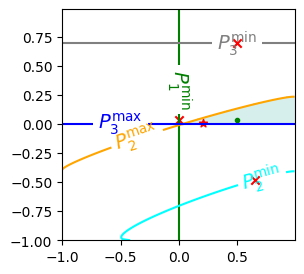

In [98]:
fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

# Plot the level sets
contour1 = ax1.contour(Z1, Z2, grids_for_P[1]-Pmax[0], levels=[0], colors='red')
contour2 = ax1.contour(Z1, Z2, grids_for_P[1]-Pmin[0], levels=[0], colors='green')
contour3 = ax1.contour(Z1, Z2, grids_for_P[2]-Pmax[1], levels=[0], colors='orange')
contour4 = ax1.contour(Z1, Z2, grids_for_P[2]-Pmin[1], levels=[0], colors='cyan')
contour5 = ax1.contour(Z1, Z2, grids_for_P[3]-Pmax[2], levels=[0], colors='blue')
contour6 = ax1.contour(Z1, Z2, grids_for_P[3]-Pmin[2], levels=[0], colors='grey')

ax1.contourf(Z1, Z2, (grids_for_P[1]<=Pmax[0]) & (grids_for_P[1]>=Pmin[0]) & (grids_for_P[2]<=Pmax[1])
                    & (grids_for_P[2]>=Pmin[1]) & (grids_for_P[3]<=Pmax[2]) & (grids_for_P[3]>=Pmin[2]), levels=[0.5, 2], cmap='GnBu', alpha=0.3)

try:
    ax1.clabel(contour1, contour1.levels, inline=True, fmt=r'$P_1^{\max}$', fontsize=14, manual=[(-0.8, 0.8)])
except:
    pass
ax1.clabel(contour2, contour2.levels, inline=True, fmt=r'$P_1^{\min}$', fontsize=14, manual=[(0.5, 0.3)])
ax1.clabel(contour3, contour3.levels, inline=True, fmt=r'$P_2^{\max}$', fontsize=14, manual=[(-0.5, 0.3)])
ax1.clabel(contour4, contour4.levels, inline=True, fmt=r'$P_2^{\min}$', fontsize=14, manual=[(0.5, 0.3)])
ax1.clabel(contour5, contour5.levels, inline=True, fmt=r'$P_3^{\max}$', fontsize=14, manual=[(-0.5, 0.3)])
ax1.clabel(contour6, contour6.levels, inline=True, fmt=r'$P_3^{\min}$', fontsize=14, manual=[(0.5, 0.3)])

for bus_i, bus_name in enumerate(bus_lists):
        # print('bus name is {}, index is {}'.format(bus_name, bus_i))
        base_point = Pi_basePoints[bus_name]
        if base_point is not None:
            zb_1 = base_point[0]
            zb_2 = base_point[1]

            ax1.scatter([zb_1], [zb_2], marker='x', color='red')

ax1.scatter([z_interior[0]], [z_interior[1]], marker='.', color='green')
ax1.scatter([z_solution[0]], [z_solution[1]], marker='*', color='red')

plt.show()

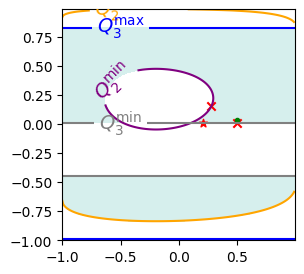

In [99]:
fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

# Plot the level sets
contour1 = ax1.contour(Z1, Z2, grids_for_Q[1]-Qmax[0], levels=[0], colors='red')
contour2 = ax1.contour(Z1, Z2, grids_for_Q[1]-Qmin[0], levels=[0], colors='green')
contour3 = ax1.contour(Z1, Z2, grids_for_Q[2]-Qmax[1], levels=[0], colors='orange')
contour4 = ax1.contour(Z1, Z2, grids_for_Q[2]-Qmin[1], levels=[0], colors='purple')
contour5 = ax1.contour(Z1, Z2, grids_for_Q[3]-Qmax[2], levels=[0], colors='blue')
contour6 = ax1.contour(Z1, Z2, grids_for_Q[3]-Qmin[2], levels=[0], colors='grey')

ax1.contourf(Z1, Z2, (grids_for_Q[1]<=Qmax[0]) & (grids_for_Q[1]>=Qmin[0]) & (grids_for_Q[2]<=Qmax[1])
                    & (grids_for_Q[2]>=Qmin[1]) & (grids_for_Q[3]<=Qmax[2]) & (grids_for_Q[3]>=Qmin[2]), levels=[0.5, 2], cmap='GnBu', alpha=0.3)

try:
    ax1.clabel(contour1, contour1.levels, inline=True, fmt=r'$P_1^{\max}$', fontsize=14, manual=[(-0.8, 0.8)])
except:
    pass
try:
    ax1.clabel(contour2, contour2.levels, inline=True, fmt=r'$Q_1^{\min}$', fontsize=14, manual=[(0.5, 0.3)])
except:
    pass
ax1.clabel(contour3, contour3.levels, inline=True, fmt=r'$Q_2^{\max}$', fontsize=14, manual=[(-0.5, 0.3)])
ax1.clabel(contour4, contour4.levels, inline=True, fmt=r'$Q_2^{\min}$', fontsize=14, manual=[(-0.5, 0.3)])
ax1.clabel(contour5, contour5.levels, inline=True, fmt=r'$Q_3^{\max}$', fontsize=14, manual=[(-0.5, 0.3)])
ax1.clabel(contour6, contour6.levels, inline=True, fmt=r'$Q_3^{\min}$', fontsize=14, manual=[(-0.5, 0.3)])

for bus_i, bus_name in enumerate(bus_lists):
        # print('bus name is {}, index is {}'.format(bus_name, bus_i))
        base_point = Qi_basePoints[bus_name]
        if base_point is not None:
            zb_1 = base_point[0]
            zb_2 = base_point[1]

            ax1.scatter([zb_1], [zb_2], marker='x', color='red')

ax1.scatter([z_interior[0]], [z_interior[1]], marker='.', color='green')
ax1.scatter([z_solution[0]], [z_solution[1]], marker='*', color='red')


plt.show()

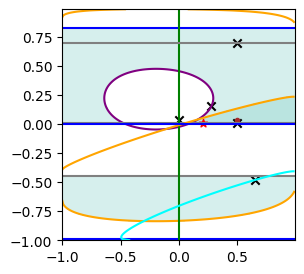

In [101]:
fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

# Plot the level sets
contourQ1 = ax1.contour(Z1, Z2, grids_for_Q[1]-Qmax[0], levels=[0], colors='red')
contourQ2 = ax1.contour(Z1, Z2, grids_for_Q[1]-Qmin[0], levels=[0], colors='green')
contourQ3 = ax1.contour(Z1, Z2, grids_for_Q[2]-Qmax[1], levels=[0], colors='orange')
contourQ4 = ax1.contour(Z1, Z2, grids_for_Q[2]-Qmin[1], levels=[0], colors='purple')
contourQ5 = ax1.contour(Z1, Z2, grids_for_Q[3]-Qmax[2], levels=[0], colors='blue')
contourQ6 = ax1.contour(Z1, Z2, grids_for_Q[3]-Qmin[2], levels=[0], colors='grey')

contourP1 = ax1.contour(Z1, Z2, grids_for_P[1]-Pmax[0], levels=[0], colors='red')
contourP2 = ax1.contour(Z1, Z2, grids_for_P[1]-Pmin[0], levels=[0], colors='green')
contourP3 = ax1.contour(Z1, Z2, grids_for_P[2]-Pmax[1], levels=[0], colors='orange')
contourP4 = ax1.contour(Z1, Z2, grids_for_P[2]-Pmin[1], levels=[0], colors='cyan')
contourP5 = ax1.contour(Z1, Z2, grids_for_P[3]-Pmax[2], levels=[0], colors='blue')
contourP6 = ax1.contour(Z1, Z2, grids_for_P[3]-Pmin[2], levels=[0], colors='grey')

ax1.contourf(Z1, Z2, (grids_for_P[1]<=Pmax[0]) & (grids_for_P[1]>=Pmin[0]) & (grids_for_P[2]<=Pmax[1])
                    & (grids_for_P[2]>=Pmin[1]) & (grids_for_P[3]<=Pmax[2]) & (grids_for_P[3]>=Pmin[2]), levels=[0.5, 2], cmap='GnBu', alpha=0.3)

ax1.contourf(Z1, Z2, (grids_for_Q[1]<=Qmax[0]) & (grids_for_Q[1]>=Qmin[0]) & (grids_for_Q[2]<=Qmax[1])
                    & (grids_for_Q[2]>=Qmin[1]) & (grids_for_Q[3]<=Qmax[2]) & (grids_for_Q[3]>=Qmin[2]), levels=[0.5, 2], cmap='GnBu', alpha=0.3)


for bus_i, bus_name in enumerate(bus_lists):
        # print('bus name is {}, index is {}'.format(bus_name, bus_i))
        base_point = Qi_basePoints[bus_name]
        if base_point is not None:
            zb_1 = base_point[0]
            zb_2 = base_point[1]

            ax1.scatter([zb_1], [zb_2], marker='x', color='black')

        base_point = Pi_basePoints[bus_name]
        if base_point is not None:
            zb_1 = base_point[0]
            zb_2 = base_point[1]

            ax1.scatter([zb_1], [zb_2], marker='x', color='black')

ax1.scatter([z_interior[0]], [z_interior[1]], marker='.', color='brown')
ax1.scatter([z_solution[0]], [z_solution[1]], marker='*', color='red')


plt.show()

# Newton Raphson method

In [ ]:
# see matlab

# SOCP